# Population structure and diversity

## Setup

In [1]:
# Load required packages
library(tidyverse)
library(wesanderson)
library(vegan)
library(umap)

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: permute
Loading required package: lattice
This is vegan 2.5-7


In [2]:
# Path to results for this project
results_prefix <- '/scratch/projects/trifolium/gwsd/results/'

In [3]:
# Sample order from ANGSD
angsd_sample_order_path <- paste0(results_prefix, 'program_resources/angsd_allFinalSamples_4fold_order.txt')
sample_order <- suppressMessages(
        read_delim(angsd_sample_order_path, col_names = FALSE, delim = '\t')
)

In [4]:
# Load sample sheet
ss_inpath <- '../resources/sequencedPlants_phenotypesHabitat.txt'
samples <- suppressMessages(
        read_delim(ss_inpath, col_names = TRUE, delim = '\t') %>%
        filter(Sample %in% sample_order$X1)
)

### Functions

In [5]:
# Function to calculate % variance and cummulative variance from PC
# Used to generate summary table rather than printing the lengthy `princomp()` summary
pca_importance <- function(x) {
  vars <- x$sdev^2
  vars <- vars/sum(vars)
  rbind(`Standard deviation` = x$sdev, `Proportion of Variance` = vars, 
      `Cumulative Proportion` = cumsum(vars))
}

# Function to load NGSadmix log files
load_ngsadmix_log <- function(path){
    seed <- as.numeric(str_extract(basename(path), pattern = '(?<=seed)[0-9]+(?=\\.log)'))
    
    logfile <- readLines(path)[9]  ## 9 index is for line with likelihood
    like <- as.numeric(str_extract(logfile, pattern = '(?<=like=)-[0-9]+\\.[0-9]+'))
    
    df_out <- data.frame(seed = seed, like = like)
    return(df_out)
}

# Function to load thetas for a given habitat
load_pi <- function(habitat){
    path <- paste0(results_prefix, sprintf('angsd/summary_stats/thetas/byHabitat/4fold_%s.thetas.idx.pestPG', habitat))
    df <- suppressMessages(read_delim(path, delim = '\t')) %>%
        mutate(tp_scaled = tP / nSites,
               tw_scaled = tW / nSites,
               habitat = habitat)
    return(df)
}

# Function to load Fst for habitat comparisons
load_fst <- function(habitat_combination){
    path <- paste0(results_prefix, sprintf('angsd/summary_stats/hudson_fst/byHabitat/4fold_%s_readable.fst', habitat_combination))
    colnames <- c('chrom', 'pos', 'num', 'denom')
    df <- suppressMessages(read_delim(path, delim = '\t', col_names = colnames)) %>%
        # Cap numerators at 0 if negative 
        # https://github.com/ANGSD/angsd/issues/309
        # Does not affect overall pattern
        mutate(num = ifelse(num < 0, 0, num)) %>% 
        
        group_by(chrom) %>%
        
        # Estimate weighted Fst as ratio of averages
        # https://github.com/ANGSD/angsd/issues/61
        summarise(num_sum = sum(num),
                  denom_sum = sum(denom),
                  fst = num_sum / denom_sum,
                  nSites = n()) %>% 
        mutate(hab_comb = habitat_combination)
    return(df)
}

# Function to load chromosomal NGSrelate results
load_relatedness <- function(path){
    chrom <- str_extract(basename(path), '^(.+)(?=_4fold)')
    df <- suppressMessages(read_delim(path, delim = '\t')) %>%
        mutate(chrom = chrom) %>%
        dplyr::select(-starts_with('J')) %>%
        dplyr::select(chrom, everything())
    return(df)
}

## Population structure

All population structure analyses were performed using 199,624 4fold SNPs from across the genome. SNPs had MAF > 0.05 and were pruned for LD such that no pairwise $r^2$ was greater than 0.2

### Pricipal Components Analysis (PCA)

- Results from a PCA performed in `pcangsd` using genotype likelihoods estimated across all samples in `ANGSD`

In [6]:
# Load covariance matrix
covMat_path <- paste0(results_prefix, 'population_structure/pcangsd/allSamples_allChroms_4fold_maf0.05_pcangsd.cov')
covMat <- suppressMessages(
        read_delim(covMat_path, col_names = FALSE, delim = ' ')
)

In [7]:
# Perform eigen decomposition of covariance matrix
# Extract eigenvectors and bind with sample sheet for plotting and coloring by habitat
eigenvectors <- eigen(covMat)
eigen_df <- eigenvectors$vectors %>%
        as.data.frame() %>%
        dplyr::select(V1, V2, V3, V4) %>%
        rename('PC1' = 'V1',
               'PC2' = 'V2',
               'PC3' = 'V3',
               'PC4' = 'V4') %>%
    bind_cols(., samples)

In [8]:
# Percent Variance explained by first 4 PCs
pca_importance(summary(princomp(covMat))) %>% 
    as.data.frame() %>% 
    rownames_to_column('var') %>% 
    dplyr::select(var, Comp.1:Comp.4)

var,Comp.1,Comp.2,Comp.3,Comp.4
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Standard deviation,0.16832949,0.12822066,0.12456946,0.11528173
Proportion of Variance,0.03390468,0.01967230,0.01856788,0.01590231
Cumulative Proportion,0.03390468,0.05357698,0.07214486,0.08804717


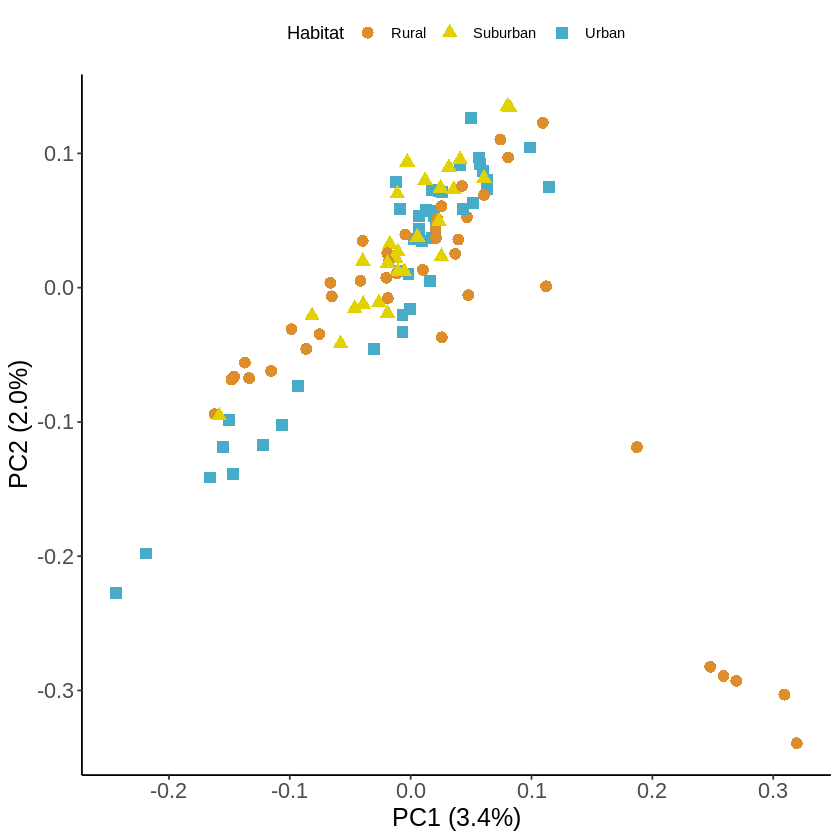

In [9]:
cols_hab <- wes_palette("FantasticFox1", n = 3, type = 'discrete')
pca_plot <- eigen_df %>%
    ggplot(., aes(x = PC1, y = PC2, color = Habitat, shape = Habitat)) +
        geom_point(size = 3) +
        scale_color_manual(values = cols_hab) +
        theme_classic() +
        xlab('PC1 (3.4%)') + ylab('PC2 (2.0%)') +
#         scale_x_continuous(breaks = seq(-0.10, 0.10, 0.10)) +
        theme(axis.text = element_text(size = 13),
              axis.title = element_text(size = 15),
              legend.position = 'top')
pca_plot

In [10]:
# What are those outlier cluster?
eigen_df %>% filter((PC1 > 0.1 & PC2 < -0.1) | (PC1 < 0.1 & PC2 < -0.15))

PC1,PC2,PC3,PC4,Sample,Habitat,Population,Plant,HCN_Result,Locus.Li,Locus.Ac
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.2189254,-0.1979378,0.36286166,0.0755048466,s_40_6,Urban,40,6,0,NA,0
-0.2438275,-0.2271833,0.27129428,0.0077840488,s_40_17,Urban,40,17,0,NA,1
0.1871879,-0.1187747,0.01110946,0.1224872216,s_7_4,Rural,7,4,1,1,NA
0.2694638,-0.2927597,-0.02236421,-0.0322387411,s_7_6,Rural,7,6,1,1,NA
0.2588995,-0.2892229,-0.02907694,0.0446461828,s_7_7,Rural,7,7,1,1,NA
0.3092221,-0.3031189,-0.02861880,0.0003486599,s_7_13,Rural,7,13,1,1,NA
0.3195286,-0.3393046,-0.04127276,0.1356788466,s_7_16,Rural,7,16,1,1,NA
0.2478445,-0.2824025,-0.05479601,-0.0207743094,s_7_19,Rural,7,19,0,1,NA


### Uniform Manifold Approximation Projection (UMAP)

- UMAP for same set of samples
- Uses number of UMAP components equal to the number of significant PCs from the PCA aboe, assessed using the broken stick model
- Takes as input a distance matrix derived from the covariance matrix of sample allele frequencies

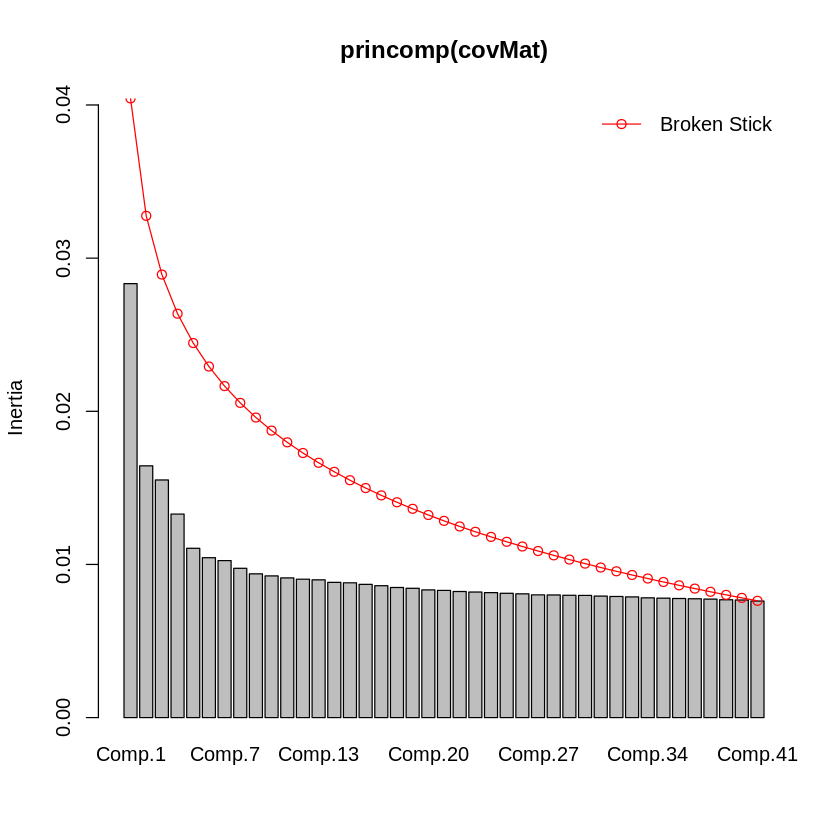

In [11]:
screeplot(princomp(covMat), bstick = TRUE, npcs = 41)

In [24]:
distMat <- as.matrix(dist(covMat))
gwsd_umap <- umap(distMat, random_state = 42, input="dist", n_neighbors = 15, min_dist = 0.1, n_components = 40)
gwsd_umap_layout <- gwsd_umap$layout %>% 
    as_tibble() %>% 
    bind_cols(., samples)

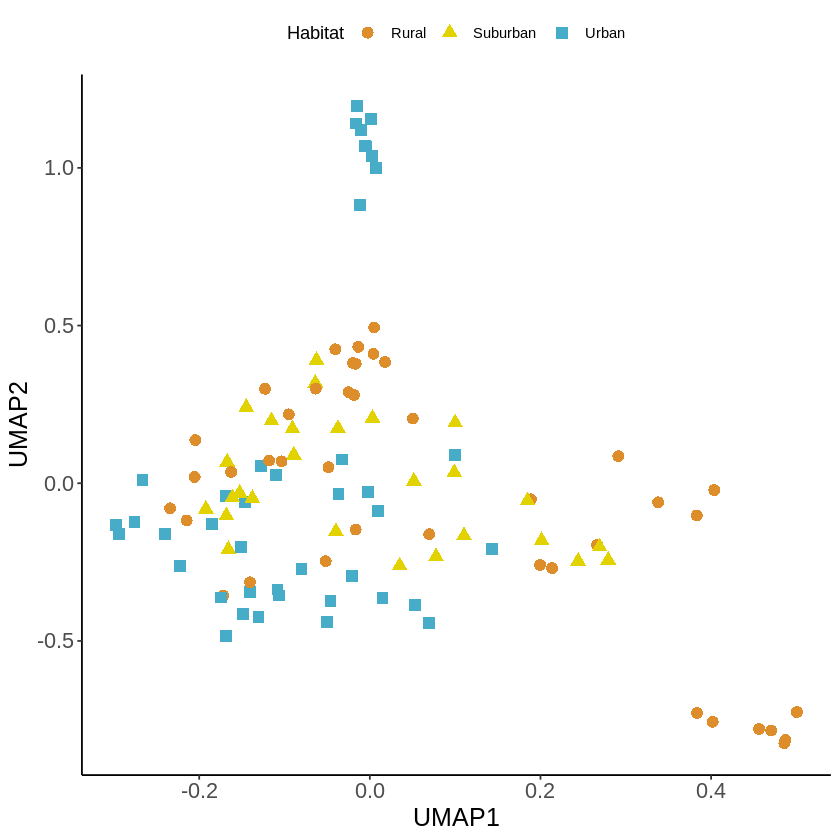

In [25]:
umap_plot <- gwsd_umap_layout %>%
    ggplot(., aes(x = V1, y = V2, color = Habitat, shape = Habitat)) +
        geom_point(size = 3) +
        scale_color_manual(values = cols_hab) +
        theme_classic() +
        xlab('UMAP1') + ylab('UMAP2') +
        theme(axis.text = element_text(size = 13),
              axis.title = element_text(size = 15),
              legend.position = 'top')
umap_plot

In [26]:
# What are those outlier cluster?
gwsd_umap_layout %>% filter((V1 > 0.3 & V2 < -0.5) | ( V1 < 0.1 & V2 > 0.5))

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V38,V39,V40,Sample,Habitat,Population,Plant,HCN_Result,Locus.Li,Locus.Ac
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.005617363,1.0697847,-0.5024424,0.157564016,-0.08232880,-1.1145068,0.067288292,-0.9609354,-0.8801344,-0.4270799,⋯,-0.5227883,0.4320739,-0.69640908,s_40_1,Urban,40,1,0,NA,0
0.002924919,1.0383909,-0.5494872,0.080856473,-0.09368992,-1.0823296,0.030548345,-0.9852586,-0.8732116,-0.3525698,⋯,-0.5201481,0.4232379,-0.67143295,s_40_3,Urban,40,3,0,NA,0
-0.016661436,1.1408276,-0.5399565,0.001989798,-0.17202259,-1.1586186,-0.008789468,-1.0383168,-0.9552968,-0.4004659,⋯,-0.4820754,0.3737000,-0.73896766,s_40_6,Urban,40,6,0,NA,0
0.007613199,0.9993781,-0.5403098,0.065795046,-0.09547859,-1.0413281,0.025307965,-0.9670805,-0.8451226,-0.3224720,⋯,-0.5067304,0.4081111,-0.68262243,s_40_7,Urban,40,7,0,NA,0
-0.011847006,0.8827060,-0.5081457,0.024444624,-0.10484058,-0.9549403,-0.011219829,-0.8942593,-0.7767693,-0.2510335,⋯,-0.4421859,0.3604042,-0.57395877,s_40_8,Urban,40,8,0,NA,1
0.001826566,1.1538633,-0.6394620,-0.035023290,-0.15110434,-1.1835670,-0.026128898,-1.1085903,-0.9861794,-0.3451421,⋯,-0.5423083,0.4256995,-0.69879378,s_40_10,Urban,40,10,0,NA,0
-0.010783260,1.1208261,-0.5761545,-0.020344187,-0.16559485,-1.1485178,-0.028249625,-1.0724708,-0.9557913,-0.3467826,⋯,-0.4952918,0.3802485,-0.72280695,s_40_12,Urban,40,12,1,NA,1
-0.004456537,1.0677289,-0.6103176,0.012872695,-0.11103849,-1.1302928,-0.016160953,-1.0470966,-0.9233735,-0.3151306,⋯,-0.5264964,0.4280305,-0.62407605,s_40_17,Urban,40,17,0,NA,1
-0.014688577,1.1952080,-0.5657764,-0.061119741,-0.21654108,-1.1883915,-0.029429363,-1.0841253,-0.9988729,-0.4072513,⋯,-0.4822951,0.3597380,-0.79391261,s_40_19,Urban,40,19,0,NA,0


### Admixture

- I estimated admixture proportions using `NGSadmix` with genotype likelihoods across all samples estimated in `ANGSD`
    - I ran all K values from 2 to 10 10 times, each with a different random seed
    - Uses same 4fold SNPs as above
- I used Evanno's delta-K method implemented in `CLUMPAK` to estimate the upper-most level of structure (i.e., "optimal" K)

In [31]:
# Best K by Evanno is 4. Load logs for K = 4
clumpak_log_path <- paste0(results_prefix, 'population_structure/bestKbyEvanno/output.log')
clumpak_log <- readLines(clumpak_log_path)
optimal_K <- clumpak_log[grep('Optimal K', clumpak_log)]
optimal_K

[1] "Tue Mar 29 10:55:30 2022: Optimal K by Evanno is: 4"

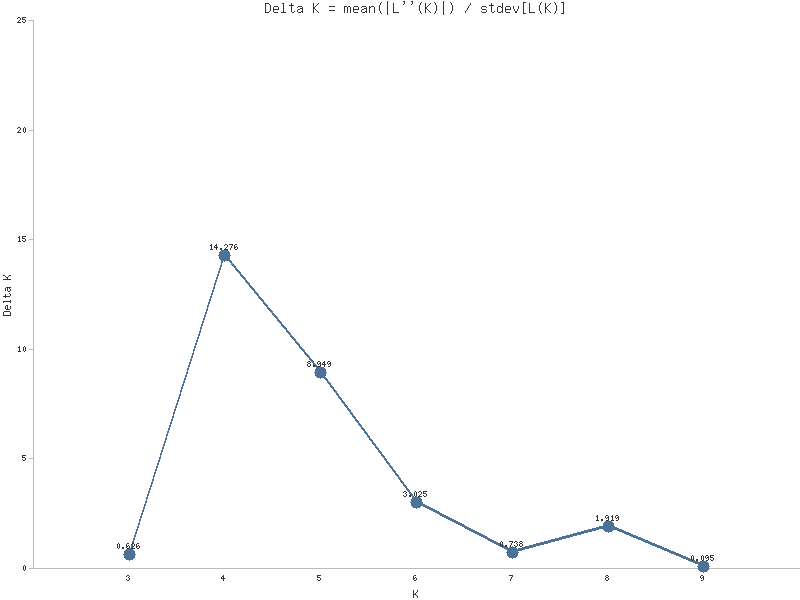

In [32]:
# Peak in Delta K looks good
library("IRdisplay")
display_png(file="/scratch/projects/trifolium/gwsd/results/population_structure/bestKbyEvanno/Best_K_By_Evanno-DeltaKByKGraph.png") 

In [33]:
ngsadmix_inpath <- paste0(results_prefix, 'population_structure/ngsadmix/K4/')
like_df <- list.files(ngsadmix_inpath, pattern = '*.log', full.names = TRUE) %>%
    map_dfr(., load_ngsadmix_log)

In [34]:
like_df

seed,like
<dbl>,<dbl>
1,-14323832
10,-14321541
2,-14321483
3,-14322796
4,-14321484
5,-14322153
6,-14324926
7,-14321572
8,-14321359


In [35]:
# Get lowest likelihood for plotting
like_df %>%
    filter(like == min(like))

seed,like
<dbl>,<dbl>
6,-14324926


In [36]:
# Load admixture results for seed with lowest log likelihood
admix_results <- paste0(results_prefix, 'population_structure/ngsadmix/K4/ngsadmix_4fold_maf0.05_K4_seed6.qopt')
admix <- suppressMessages(read_delim(admix_results, col_names = FALSE, delim = " ")) %>%
    dplyr::select(-X5) %>%
    bind_cols(., samples) %>% 
    pivot_longer(X1:X4, values_to = 'Probs') %>% 
    mutate(Probs = round(Probs, 5))
head(admix)

Sample,Habitat,Population,Plant,HCN_Result,Locus.Li,Locus.Ac,name,Probs
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
s_40_1,Urban,40,1,0,NA,0,X1,0.27582
s_40_1,Urban,40,1,0,NA,0,X2,0.72418
s_40_1,Urban,40,1,0,NA,0,X3,0.00000
s_40_1,Urban,40,1,0,NA,0,X4,0.00000
s_40_3,Urban,40,3,0,NA,0,X1,0.00000
s_40_3,Urban,40,3,0,NA,0,X2,1.00000


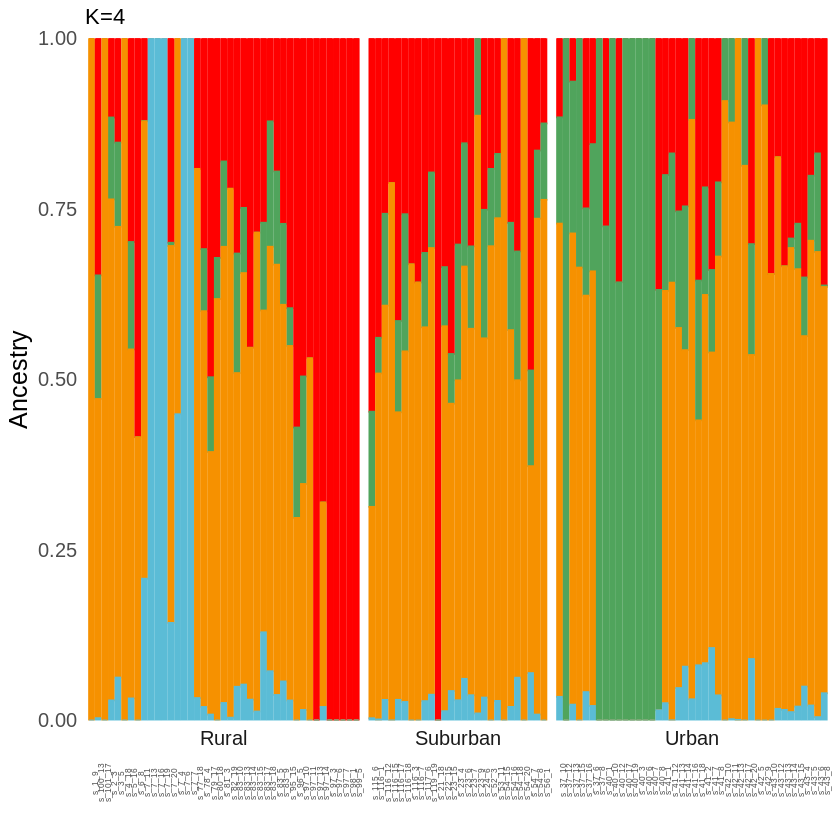

In [37]:
cols_admix <- wes_palette("Darjeeling1", n = 4, type = 'continuous')
admix_plot <- 
  ggplot(admix, aes(factor(Sample), Probs, fill = factor(name), color = factor(name))) +
  geom_col(width=0.75) +
  facet_grid(~fct_relevel(Habitat,'Rural', 'Suburban', 'Urban'), switch = "x", scales = "free", space = "free") +
  theme_minimal() + labs(x = "", title = "K=4", y = "Ancestry") +
  scale_y_continuous(expand = c(0, 0)) +
  scale_x_discrete(expand = expansion(add = 1)) +
  scale_fill_manual(values = cols_admix) + 
  scale_color_manual(values = cols_admix) +
  theme(
    legend.position = 'none',
    panel.spacing.x = unit(0.1, "lines"),
    axis.text.x = element_text(size=5, angle = 90),
    panel.grid = element_blank(),
    axis.text = element_text(size=12),
    axis.title = element_text(size=15),
    strip.text.x = element_text(size = 12)
  ) 
admix_plot

### Pi and Fst

- Pi and Fst were estimated in `ANGSD` using the same 4fold sites as above

#### By Habitat

- Pi in each of 3 habitats
- Pairwise Fst across all 3 habitat types
- TODO: Consider ammending this to estimate all 3 pairwise comparison at once so that `ANGSD` also estimates the population branch statistic

In [42]:
# Load in thetas for all habitats and merge into single dataframe
pi_stats <- purrr::map_dfr(c('Urban', 'Suburban', 'Rural'), load_pi)

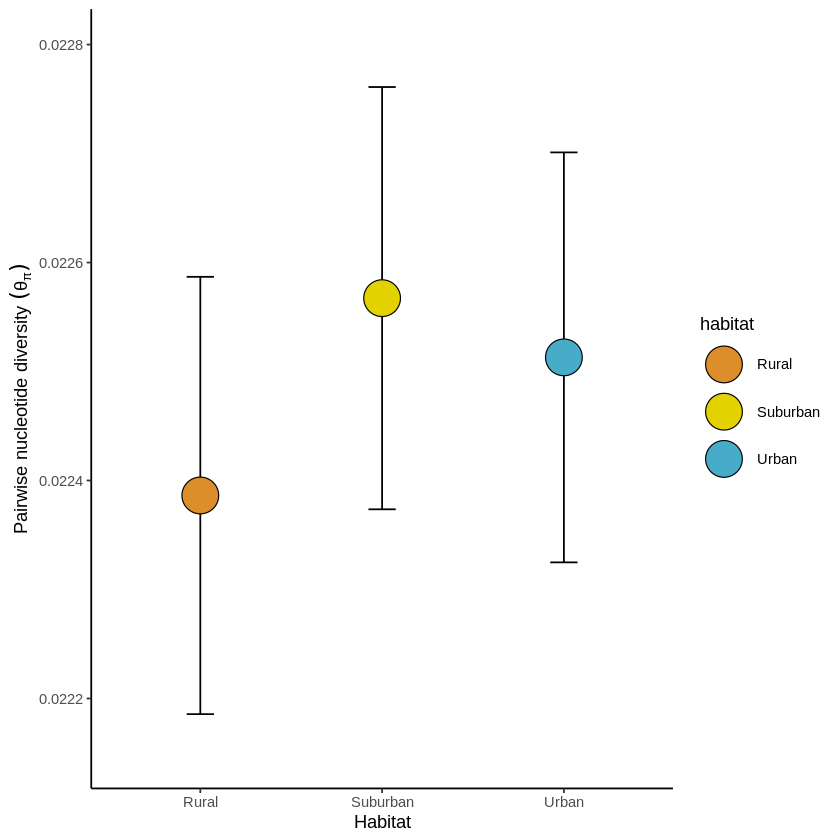

In [44]:
pi_stats %>%
    group_by(habitat) %>%
    summarise(mean_tp = mean(tp_scaled),
              sd_tp = sd(tp_scaled),
              se_tp = sd_tp / sqrt(n())) %>%
    ggplot(., aes(x = habitat, y = mean_tp)) +
        geom_errorbar(aes(ymin = mean_tp - se_tp, ymax = mean_tp + se_tp), width = 0.15) +
        geom_point(size = 10, shape = 21, aes(fill = habitat)) +
        xlab('Habitat') + ylab(expression(Pairwise~nucleotide~diversity~('\u03B8'['\u03C0']))) +
        scale_fill_manual(values = cols_hab) +
        coord_cartesian(ylim = c(0.02215, 0.02280)) +
        theme_classic()

In [45]:
# Load in fst for all habitat comparisons and merge into single dataframe
fst_stats <- purrr::map_dfr(c('Rural_Suburban', 'Urban_Rural', 'Urban_Suburban'), load_fst)

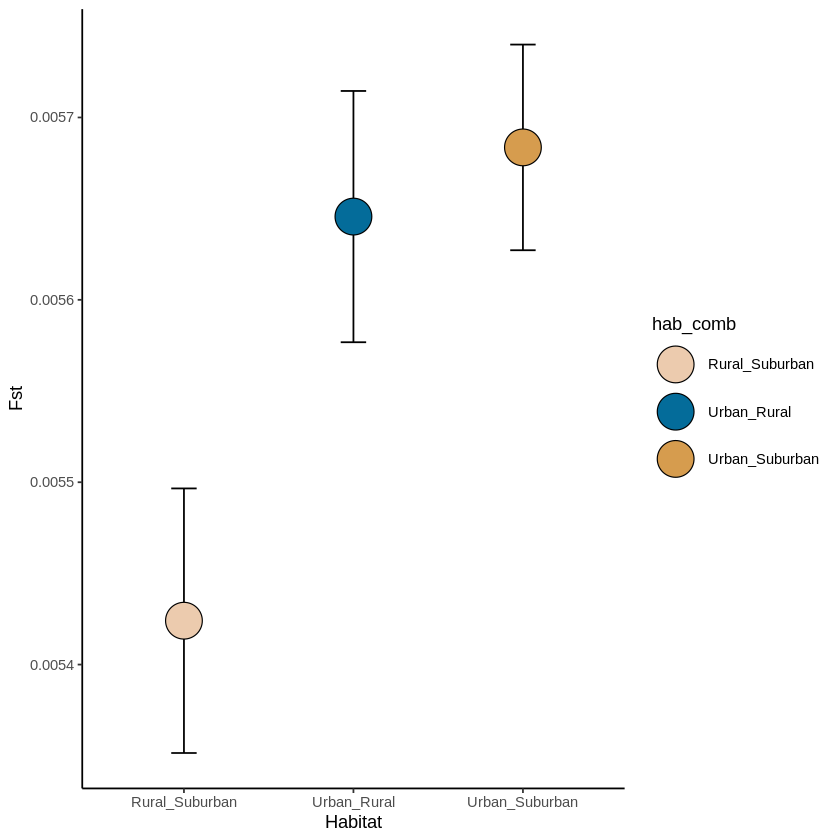

In [46]:
fst_cols <- wes_palette("Darjeeling2", n = 3)
fst_stats %>%
    group_by(hab_comb) %>%
    summarise(mean_fst = mean(fst),
              sd_fst = sd(fst),
              se_fst = sd_fst / sqrt(n())) %>%
    ggplot(., aes(x = hab_comb, y = mean_fst)) +
        geom_errorbar(aes(ymin = mean_fst - se_fst, ymax = mean_fst + se_fst), width = 0.15) +
        geom_point(size = 10, shape = 21, aes(fill = hab_comb)) +
        xlab('Habitat') + ylab("Fst") +
        scale_fill_manual(values = fst_cols) +
#         coord_cartesian(ylim = c(0.02210, 0.0230)) +
        theme_classic()

### Relatedness

- I estimated pairwise relatedness across all samples using genotype likelihoods estimated in `ANGSD`
- Uses same 4fold SNPs as above

In [47]:
# Load all chromosomal NGSrelate results and combine into single DF
ngsrelate_output_path <- paste0(results_prefix, 'population_structure/ngsrelate')
relate_df <- list.files(ngsrelate_output_path, pattern = '*.out', full.names = TRUE) %>%
    purrr::map_dfr(., load_relatedness)

In [48]:
# Get order of samples that were used as input to NGSrelate
# Uses all high quality samples (N = 115)
bam_list_path <- paste0(results_prefix, 'program_resources/bam_lists/highQualSamples_4fold_bams.list')
relate_sample_list <- suppressMessages(read_table(bam_list_path, col_names = 'bam')) %>%
    mutate(sample = str_extract(basename(bam), '(s_\\d+_\\d+)(?=_4fold)')) %>%
    separate(sample, into = c('tmp', 'pop', 'ind'), sep = '_', remove = FALSE) %>%
    dplyr::select(-tmp, -bam) %>%
    mutate(idx = seq(from = 0, to = n() - 1))

In [49]:
# Bind sample names to NGSrelate sample IDs
# Add population and habitat info for later comparisons of relatedness among habitats
pops_habitat <- samples %>% 
    rename('pop' = 'Population') %>% 
    dplyr::select(pop, Habitat) %>%
    mutate(pop = as.character(pop)) %>%
    distinct()
relate_df_withHab <- relate_df %>%
    pivot_longer(cols = c('a', 'b'), values_to = 'idx') %>%
    left_join(., relate_sample_list, by = 'idx') %>%
    dplyr::select(-idx) %>%
    left_join(., pops_habitat, by = 'pop') %>%
    pivot_wider(values_from = c('sample', 'pop', 'ind', 'Habitat'))

In [50]:
# Calculate mean relatedness across chromosomes for each sample comparison
mean_relate_acrossChroms <- relate_df_withHab %>%
    group_by(sample_a, sample_b) %>%
    summarise(mean_rab_acrossChroms = mean(rab),
              n = n()) %>%
    left_join(., relate_df_withHab %>%
              dplyr::select(sample_a, sample_b, pop_a, pop_b, Habitat_a, Habitat_b) %>%
              distinct(),
             by = c('sample_a', 'sample_b')) %>%
    ungroup()

`summarise()` has grouped output by 'sample_a'. You can override using the `.groups` argument.


In [51]:
# Calculate mean relatedness across samples for specific habitat comparisons
mean_relate_acrossHabs <- mean_relate_acrossChroms %>%
    mutate(comparison = case_when(Habitat_a == 'Urban' & Habitat_b == 'Urban' ~ 'Within Urban',
                                  Habitat_a == 'Suburban' & Habitat_b == 'Suburban' ~ 'Within Suburban',
                                  Habitat_a == 'Rural' & Habitat_b == 'Rural' ~ 'Within Rural',
                                  
                                  Habitat_a == 'Urban' & Habitat_b == 'Suburban' ~ 'Urban-Suburban',
                                  Habitat_a == 'Suburban' & Habitat_b == 'Urban' ~ 'Urban-Suburban',
                                  
                                  Habitat_a == 'Urban' & Habitat_b == 'Rural' ~ 'Urban-Rural',
                                  Habitat_a == 'Rural' & Habitat_b == 'Urban' ~ 'Urban-Rural',
                                  
                                  Habitat_a == 'Suburban' & Habitat_b == 'Rural' ~ 'Suburban-Rural',
                                  Habitat_a == 'Rural' & Habitat_b == 'Suburban' ~ 'Suburban-Rural')) %>%
    group_by(comparison) %>%
    summarise(mean_rab = mean(mean_rab_acrossChroms),
              sd_rab = sd(mean_rab_acrossChroms),
              se_rab = sd_rab / sqrt(n()))

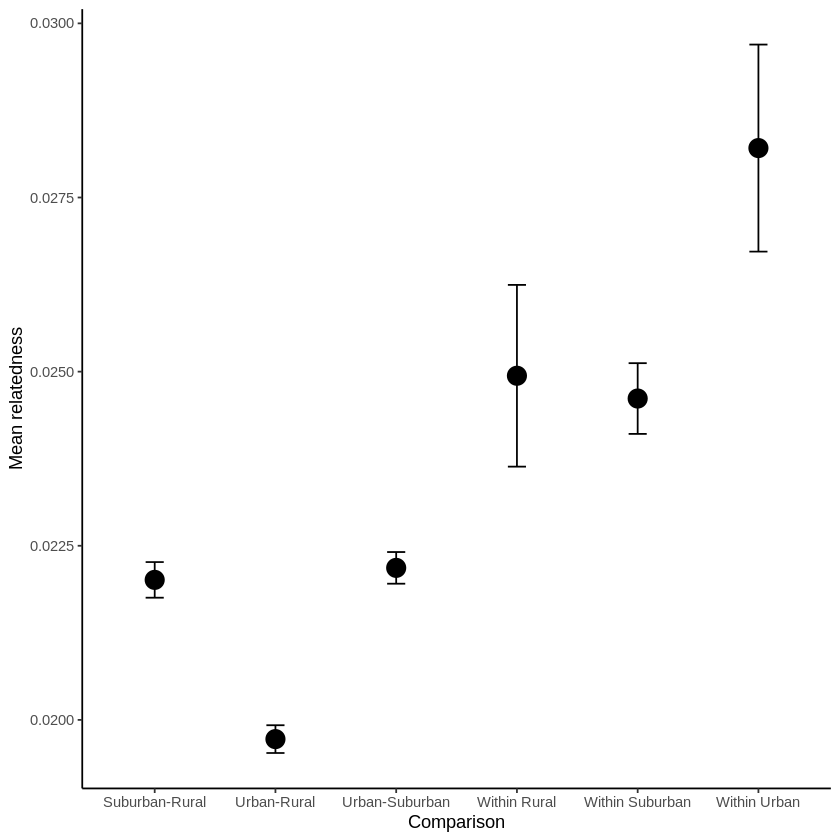

In [52]:
# Plot relatedness comparisons
mean_relate_acrossHabs %>%
    ggplot(., aes(x = comparison, y = mean_rab)) +
    geom_errorbar(aes(ymin = mean_rab - se_rab, ymax = mean_rab + se_rab), width = 0.15) +
    geom_point(size = 5) +
    xlab('Comparison') + ylab('Mean relatedness') +
    scale_fill_manual(values = cols_hab) +
    theme_classic()

In [59]:
mean_relate_acrossChroms %>%
    arrange(desc(mean_rab_acrossChroms)) %>%
    head(n = 10)

sample_a,sample_b,mean_rab_acrossChroms,n,pop_a,pop_b,Habitat_a,Habitat_b
<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>
s_37_6,s_37_18,0.7689807,16,37,37,Urban,Urban
s_97_9,s_97_14,0.7678698,16,97,97,Rural,Rural
s_42_3,s_42_9,0.7467403,16,42,42,Urban,Urban
s_83_5,s_83_11,0.7194610,16,83,83,Rural,Rural
s_42_1,s_42_20,0.7135305,16,42,42,Urban,Urban
s_37_11,s_37_18,0.4029149,16,37,37,Urban,Urban
s_37_6,s_37_11,0.3960961,16,37,37,Urban,Urban
s_37_8,s_37_12,0.2690484,16,37,37,Urban,Urban
s_7_6,s_7_13,0.2211006,16,7,7,Rural,Rural


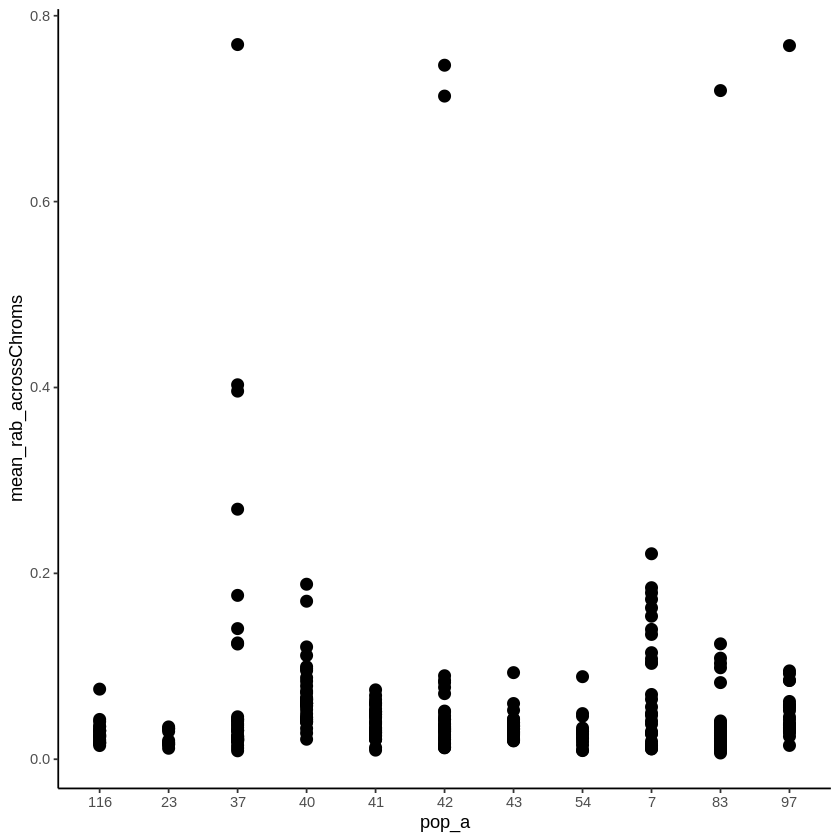

In [124]:
mean_relate_acrossChroms %>% filter((Habitat_a == Habitat_b) & (pop_a == pop_b)) %>% 
    ggplot(., aes(x = pop_a, y = mean_rab_acrossChroms)) +
    geom_point(size = 3, color = 'black') +
    theme_classic()